In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import math
import pprint
from sklearn import preprocessing
import re

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer, sent_tokenize
import nltk
nltk.download('punkt')
from nltk import word_tokenize

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mattcirelli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Update SIA with Loughran McDonald Dictionary

import csv
import pandas as pd

# stock market lexicon
stock_lex = pd.read_csv('stock_lex.csv')

stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

#update the positive and negative dictionaries
positive = []
reader = csv.reader('lm_positive.csv')
for row in reader:
    positive.append(row[0].strip())
    
negative = []
reader = csv.reader('lm_negative.csv')
for row in reader:
    entry = row[0].strip().split(" ")
    if len(entry) > 1:
        negative.extend(entry)
    else:
        negative.append(entry[0])

final_lex = {}
final_lex.update({word:2.0 for word in positive})
final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [4]:
data = pd.read_csv('JPM_news.csv')

In [5]:
data.head()

,Unnamed: 0,company,id,publication_date,summary,title,url
0,0,NaN,nws_OrERqO,2019-08-07 22:03:39+00:00,S&P; 500 up 0.08% Continue reading...,US Indexes Close Mostly Higher for a 2nd Day o...,https://finance.yahoo.com/news/us-indexes-clos...
1,1,NaN,nws_7KVPGP,2019-08-07 19:47:50+00:00,Love it or hate it - research and development ...,Expanding Their Reach: Top 6 Institutions Oper...,https://finance.yahoo.com/news/expanding-reach...
2,2,NaN,nws_xY9BeN,2019-08-07 19:20:02+00:00,Global equities are reeling again on Wednesday...,5 Big Bank Stocks to Sell as Central Banks Cut...,https://finance.yahoo.com/news/5-big-bank-stoc...
3,3,NaN,nws_alOY4L,2019-08-07 19:01:00+00:00,Lower rates are terrible unless you spend mone...,"Jim Cramer: In America, Lower Rates Are Nirvan...",https://finance.yahoo.com/m/ce1634b1-0ea5-39c1...
4,4,NaN,nws_7KVP07,2019-08-07 18:06:54+00:00,JPMorgan Chase opened the doors to its new Cha...,JPMorgan Chase opens its first North Carolina ...,https://finance.yahoo.com/m/5a948a94-133d-3c8a...


In [6]:
data['publication_date']=pd.to_datetime(data.publication_date,format='%Y-%m-%d')
data.index =data['publication_date']


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17876 entries, 2019-08-07 22:03:39 to 2015-07-21 19:12:17
Data columns (total 7 columns):
Unnamed: 0          17876 non-null int64
company             0 non-null float64
id                  17876 non-null object
publication_date    17876 non-null datetime64[ns]
summary             17871 non-null object
title               17876 non-null object
url                 17876 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.1+ MB


In [8]:
data.head()

,Unnamed: 0,company,id,publication_date,summary,title,url
publication_date,,,,,,,
2019-08-07 22:03:39,0,NaN,nws_OrERqO,2019-08-07 22:03:39,S&P; 500 up 0.08% Continue reading...,US Indexes Close Mostly Higher for a 2nd Day o...,https://finance.yahoo.com/news/us-indexes-clos...
2019-08-07 19:47:50,1,NaN,nws_7KVPGP,2019-08-07 19:47:50,Love it or hate it - research and development ...,Expanding Their Reach: Top 6 Institutions Oper...,https://finance.yahoo.com/news/expanding-reach...
2019-08-07 19:20:02,2,NaN,nws_xY9BeN,2019-08-07 19:20:02,Global equities are reeling again on Wednesday...,5 Big Bank Stocks to Sell as Central Banks Cut...,https://finance.yahoo.com/news/5-big-bank-stoc...
2019-08-07 19:01:00,3,NaN,nws_alOY4L,2019-08-07 19:01:00,Lower rates are terrible unless you spend mone...,"Jim Cramer: In America, Lower Rates Are Nirvan...",https://finance.yahoo.com/m/ce1634b1-0ea5-39c1...
2019-08-07 18:06:54,4,NaN,nws_7KVP07,2019-08-07 18:06:54,JPMorgan Chase opened the doors to its new Cha...,JPMorgan Chase opens its first North Carolina ...,https://finance.yahoo.com/m/5a948a94-133d-3c8a...


In [9]:
str(data["summary"])

"publication_date\n2019-08-07 22:03:39                S&P; 500 up 0.08% Continue reading...\n2019-08-07 19:47:50    Love it or hate it - research and development ...\n2019-08-07 19:20:02    Global equities are reeling again on Wednesday...\n2019-08-07 19:01:00    Lower rates are terrible unless you spend mone...\n2019-08-07 18:06:54    JPMorgan Chase opened the doors to its new Cha...\n2019-08-07 17:52:05                         Style Box ETF report for IWX\n2019-08-07 17:29:00    Investing.com – Stocks found a footing after p...\n2019-08-07 14:41:02    The Zacks Analyst Blog Highlights: JPMorgan Ch...\n2019-08-07 13:27:01    HSBC Holdings' (HSBC) agreement to settle Belg...\n2019-08-07 12:46:53    (Bloomberg) -- It took a $650,000 salary for M...\n2019-08-07 11:00:58    Gold Briefly Breaks Through $1,500, JPMorgan S...\n2019-08-07 09:36:00    Investing.com - JPMorgan (NYSE:JPM) fell by 3....\n2019-08-07 09:22:44    (Bloomberg) -- China’s central bank set its da...\n2019-08-07 09:04:12

In [10]:
#drop any duplicated headlines
data = data.sort_values(['summary']).drop_duplicates(subset='title')
data = data.sort_values(['publication_date'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'publication_date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# Concatenate all news into one
#data["summary"] = data.filter(regex=("Top.*")).apply(lambda x: ''.join(str(x.values)), axis=1)

In [12]:
#Tokenize Words Data 
text=data["summary"][1]
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(text)
print(tokenized_word)

['BNP', 'Paribas', 'to', 'pay', '$', '115', 'mln', 'to', 'settle', 'currency-rigging', 'lawsuit', '-', 'source']


In [13]:
##Tokenize Sentences Data
from nltk.tokenize import sent_tokenize
tokenized_text=sent_tokenize(text)
print(tokenized_text)

['BNP Paribas to pay $115 mln to settle currency-rigging lawsuit - source']


In [14]:
#Import English Stopwords
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'other', 'after', 'again', 'couldn', 'yours', 'me', "mustn't", 'hasn', 'doesn', 'very', "you'll", 'there', 'this', 'few', 'can', 'doing', 's', 'same', 'both', 'be', 'haven', 'do', 'from', 'those', 'for', 'below', 'he', 'm', "aren't", 'up', 'itself', 'her', 'didn', 'him', "wasn't", 'any', 'once', 'against', "isn't", 'as', "weren't", 'off', 'and', 'their', 'is', 'during', 'such', 'ma', 'll', 'himself', 'further', 'when', 'each', "hasn't", 'no', "didn't", 'under', 'about', "wouldn't", 'my', 'its', 'did', 've', 'o', 'now', 'needn', 'but', 'hadn', 'with', "it's", "you've", "doesn't", 'own', 'being', 'some', "hadn't", 'until', 'or', 'at', 'his', 'nor', 'them', 'that', 'it', 'had', 'over', 'so', "don't", 'not', 'was', 'mustn', 'having', 'wouldn', "needn't", 'on', 'above', "should've", 'does', 'are', 'we', 'whom', 'in', 'mightn', 'am', "mightn't", 'myself', 'into', 'ourselves', 'isn', 'who', "you're", 'don', 'before', "couldn't", 'too', 'then', 'herself', 'hers', 'our', 'all', 'ours', 'an', '

In [15]:
#Filter Stopwords
filtered_sent=[]
for w in tokenized_text:
    if w not in stop_words:
        filtered_sent.append(w)
print("Tokenized Sentence:",tokenized_text)
print("Filterd Sentence:",filtered_sent)

Tokenized Sentence: ['BNP Paribas to pay $115 mln to settle currency-rigging lawsuit - source']
Filterd Sentence: ['BNP Paribas to pay $115 mln to settle currency-rigging lawsuit - source']


https://github.com/Currie32/Predicting-the-Dow-Jones-with-Headlines/blob/master/Predict_Dow_with_News.ipynb
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

# Clean the headlines
clean_headlines = []

for daily_headlines in data["summary"]:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [16]:
str(data["title"])

"publication_date\n2015-07-21 19:12:17    Citi ordered to pay $770 million over credit c...\n2015-08-14 17:16:07    BNP Paribas to pay $115 mln to settle currency...\n2015-09-17 22:39:02    Wall Street banks eye December for Fed liftoff...\n2015-10-05 16:43:23    Global business growth at weakest pace this ye...\n2015-10-13 14:09:06    Barclays set to name former JPMorgan banker St...\n2015-10-14 00:17:23        JPMorgan goes on a diet to appease regulators\n2015-10-15 18:19:27    Goldman profit plunges as market turmoil hits ...\n2015-12-02 22:37:26    Exclusive: Barclays' boss wants Blythe Masters...\n2015-12-28 21:14:43    JPMorgan to raise deposit rates for some big c...\n2016-01-14 17:54:08    JPMorgan strikes confident tone after better-t...\n2016-01-29 00:20:44    Wells Fargo, BofA look to integrate Apple Pay ...\n2016-02-22 10:06:00    JPMorgan may hold steady on cost target despit...\n2016-03-16 22:11:24    JPMorgan, Citi shareholders to vote on potenti...\n2016-03-22 14:11:33

In [17]:
print(data["summary"])

publication_date
2015-07-21 19:12:17    Citi ordered to pay $770 million over credit c...
2015-08-14 17:16:07    BNP Paribas to pay $115 mln to settle currency...
2015-09-17 22:39:02    Wall Street banks eye December for Fed liftoff...
2015-10-05 16:43:23    Global business growth at weakest pace this ye...
2015-10-13 14:09:06    Barclays set to name former JPMorgan banker St...
2015-10-14 00:17:23        JPMorgan goes on a diet to appease regulators
2015-10-15 18:19:27    Goldman profit plunges as market turmoil hits ...
2015-12-02 22:37:26    Exclusive: Barclays' boss wants Blythe Masters...
2015-12-28 21:14:43    JPMorgan to raise deposit rates for some big c...
2016-01-14 17:54:08    JPMorgan strikes confident tone after better-t...
2016-01-29 00:20:44    Wells Fargo, BofA look to integrate Apple Pay ...
2016-02-22 10:06:00    JPMorgan may hold steady on cost target despit...
2016-03-16 22:11:24    JPMorgan, Citi shareholders to vote on potenti...
2016-03-22 14:11:33    Edelweiss b

### SIA compound score Calculation 
https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/


In [20]:
sia = SIA()
results = []

for line in data["title"]:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

print(results[:3])

[{'neg': 0.117, 'neu': 0.667, 'pos': 0.217, 'compound': 0.296, 'headline': 'Citi ordered to pay $770 million over credit card practices'}, {'neg': 0.268, 'neu': 0.732, 'pos': 0.0, 'compound': -0.3182, 'headline': 'BNP Paribas to pay $115 mln to settle currency-rigging lawsuit - source'}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'headline': 'Wall Street banks eye December for Fed liftoff - Reuters poll'}]


In [21]:
df123 = pd.DataFrame(results)
#df123['publication_date'] = data['publication_date']
#df123.Date = pd.to_datetime(df123.publication_date)
#df123.set_index('publication_date', inplace=True)
df123.head()

,compound,headline,neg,neu,pos
0,0.2960,Citi ordered to pay $770 million over credit c...,0.117,0.667,0.217
1,-0.3182,BNP Paribas to pay $115 mln to settle currency...,0.268,0.732,0.000
2,0.0000,Wall Street banks eye December for Fed liftoff...,0.000,1.000,0.000
3,-0.1779,Global business growth at weakest pace this ye...,0.221,0.604,0.174
4,0.0000,Barclays set to name former JPMorgan banker St...,0.000,1.000,0.000


In [22]:
print(df123['headline'][1])

BNP Paribas to pay $115 mln to settle currency-rigging lawsuit - source


In [23]:
df123.describe()

,compound,neg,neu,pos
count,13933.000000,13933.000000,13933.000000,13933.000000
mean,0.078308,0.044418,0.862003,0.093579
std,0.286697,0.103161,0.168421,0.141857
min,-0.925300,0.000000,0.146000,0.000000
25%,0.000000,0.000000,0.738000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,0.250000,0.000000,1.000000,0.196000
max,0.920600,0.737000,1.000000,0.854000


In [24]:
df123.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13933 entries, 0 to 13932
Data columns (total 5 columns):
compound    13933 non-null float64
headline    13933 non-null object
neg         13933 non-null float64
neu         13933 non-null float64
pos         13933 non-null float64
dtypes: float64(4), object(1)
memory usage: 544.3+ KB


In [25]:
df123['label'] = 0
df123.loc[df123['compound'] > 0.1, 'label'] = 1
df123.loc[df123['compound'] < -0.1, 'label'] = -1
df123.head()

,compound,headline,neg,neu,pos,label
0,0.2960,Citi ordered to pay $770 million over credit c...,0.117,0.667,0.217,1
1,-0.3182,BNP Paribas to pay $115 mln to settle currency...,0.268,0.732,0.000,-1
2,0.0000,Wall Street banks eye December for Fed liftoff...,0.000,1.000,0.000,0
3,-0.1779,Global business growth at weakest pace this ye...,0.221,0.604,0.174,-1
4,0.0000,Barclays set to name former JPMorgan banker St...,0.000,1.000,0.000,0


In [26]:
print("Positive headlines:\n")
print(list(df123[df123['label'] == 1].headline)[:5])


Positive headlines:

['Citi ordered to pay $770 million over credit card practices', 'JPMorgan goes on a diet to appease regulators', 'Goldman profit plunges as market turmoil hits bond trading', "Exclusive: Barclays' boss wants Blythe Masters to run investment bank - source", 'JPMorgan strikes confident tone after better-than-expected results']


In [27]:
print("\nNegative headlines:\n")
print(list(df123[df123['label'] == -1].headline)[:5])


Negative headlines:

['BNP Paribas to pay $115 mln to settle currency-rigging lawsuit - source', 'Global business growth at weakest pace this year in Sept - PMI', 'JPMorgan may hold steady on cost target despite low interest rates', 'Germany predicts drop in exports to Britain due to EU exit', 'UK must consider pace of deficit reduction - finance minister Hammond']


In [28]:
print(df123.label.value_counts())

print(df123.label.value_counts(normalize=True) * 100)

 0    7754
 1    4275
-1    1904
Name: label, dtype: int64
 0    55.652049
 1    30.682552
-1    13.665399
Name: label, dtype: float64


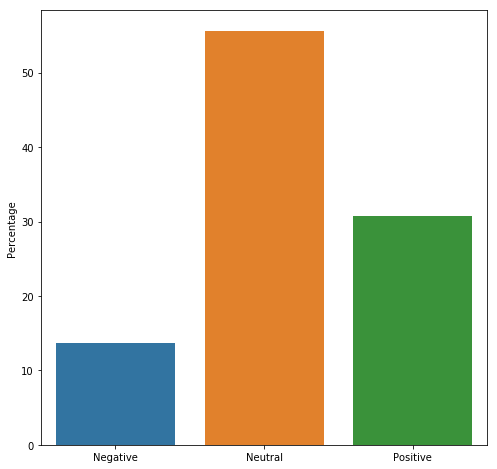

In [29]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8))

counts = df123.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Count')

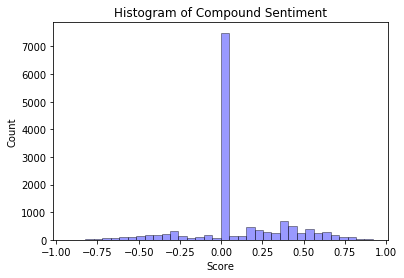

In [30]:

# seaborn histogram
sns.distplot(df123['compound'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Compound Sentiment')
plt.xlabel('Score')
plt.ylabel('Count')

In [31]:
#https://github.com/llSourcell/Stock_Market_Prediction/blob/master/Generating%20Different%20Models.ipynb
#import numpy as np
#import pandas as pd
#from nltk.classify import NaiveBayesClassifier
#from nltk.corpus import subjectivity
#from nltk.sentiment import SentimentAnalyzer
#from nltk.sentiment.util import *
#import nltk
#nltk.downloader.download('vader_lexicon')

#sentence = 'paris shootout police officer suspected guman dead'
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#import unicodedata
#sid = SentimentIntensityAnalyzer()
#ss = sid.polarity_scores(sentence)
#ss

In [32]:
df123.index =data['publication_date']
df123.head()

,compound,headline,neg,neu,pos,label
publication_date,,,,,,
2015-07-21 19:12:17,0.2960,Citi ordered to pay $770 million over credit c...,0.117,0.667,0.217,1
2015-08-14 17:16:07,-0.3182,BNP Paribas to pay $115 mln to settle currency...,0.268,0.732,0.000,-1
2015-09-17 22:39:02,0.0000,Wall Street banks eye December for Fed liftoff...,0.000,1.000,0.000,0
2015-10-05 16:43:23,-0.1779,Global business growth at weakest pace this ye...,0.221,0.604,0.174,-1
2015-10-13 14:09:06,0.0000,Barclays set to name former JPMorgan banker St...,0.000,1.000,0.000,0


In [33]:
df123.to_csv('JPM_sent_news.csv')